In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional

GT_path = '/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test_full/'
reconstruction_ZF_path = '/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Reconstructions/ZeroFilled/reconstructions/'
reconstruction_ZF_noACS_path = '/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Reconstructions/ZeroFilledNoACS/reconstructions/'
reconstruction_grappa_path = '/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Reconstructions/Grappa/reconstructions/'
reconstruction_sense_path = '/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Reconstructions/Sense/reconstructions/'
reconstruction_CS_path = '/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Reconstructions/CS/reconstructions/'
reconstruction_ZF_unet_path = '/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Reconstructions/BaselineUNet/Epoch47/reconstructions_regularized/'
reconstruction_ZF_unet_noACS_path = '/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Reconstructions/BaselineUNetSenseMask/Epoch48/reconstructions_regularized/'
reconstruction_grappa_unet_path = '/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Reconstructions/GrappaUNet/Epoch48/reconstructions_regularized/'
reconstruction_sense_unet_path = '/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Reconstructions/SenseUNet/Epoch48/reconstructions/'
reconstruction_cs_unet_path = '/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Reconstructions/CSUNet/Epoch49/reconstructions/'

file = 'file_brain_AXFLAIR_210_6001516.h5'  # R = 8 (global 24th-26th percentile)
slice = 3

GT_path = os.path.join(GT_path,file)
reconstruction_ZF_path = os.path.join(reconstruction_ZF_path,file)
reconstruction_ZF_noACS_path = os.path.join(reconstruction_ZF_noACS_path,file)
reconstruction_grappa_path = os.path.join(reconstruction_grappa_path,file)
reconstruction_sense_path = os.path.join(reconstruction_sense_path,file)
reconstruction_CS_path = os.path.join(reconstruction_CS_path,file)
reconstruction_ZF_unet_path = os.path.join(reconstruction_ZF_unet_path,file)
reconstruction_ZF_unet_noACS_path = os.path.join(reconstruction_ZF_unet_noACS_path,file)
reconstruction_grappa_unet_path = os.path.join(reconstruction_grappa_unet_path,file)
reconstruction_sense_unet_path = os.path.join(reconstruction_sense_unet_path,file)
reconstruction_cs_unet_path = os.path.join(reconstruction_cs_unet_path,file)

GT = h5py.File(GT_path, 'r')
reconstruction_ZF = h5py.File(reconstruction_ZF_path, 'r')
reconstruction_ZF_noACS = h5py.File(reconstruction_ZF_noACS_path, 'r')
reconstruction_grappa = h5py.File(reconstruction_grappa_path, 'r')
reconstruction_sense = h5py.File(reconstruction_sense_path, 'r')
reconstruction_CS = h5py.File(reconstruction_CS_path, 'r')
reconstruction_ZF_unet = h5py.File(reconstruction_ZF_unet_path, 'r')
reconstruction_ZF_unet_noACS = h5py.File(reconstruction_ZF_unet_noACS_path, 'r')
reconstruction_grappa_unet = h5py.File(reconstruction_grappa_unet_path, 'r')
reconstruction_sense_unet = h5py.File(reconstruction_sense_unet_path, 'r')
reconstruction_cs_unet = h5py.File(reconstruction_cs_unet_path, 'r')


In [2]:
GT = GT['reconstruction_rss']
reconstruction_ZF = reconstruction_ZF['reconstruction']
reconstruction_ZF_noACS = reconstruction_ZF_noACS['reconstruction']
reconstruction_grappa = reconstruction_grappa['reconstruction']
reconstruction_sense = reconstruction_sense['reconstruction']
reconstruction_CS = reconstruction_CS['reconstruction']
reconstruction_ZF_unet = reconstruction_ZF_unet['reconstruction']
reconstruction_ZF_unet_noACS = reconstruction_ZF_unet_noACS['reconstruction']
reconstruction_grappa_unet = reconstruction_grappa_unet['reconstruction']
reconstruction_sense_unet = reconstruction_sense_unet['reconstruction']
reconstruction_cs_unet = reconstruction_cs_unet['reconstruction']


In [3]:
GT = np.array(GT)
reconstruction_ZF = np.array(reconstruction_ZF)
reconstruction_ZF_noACS = np.array(reconstruction_ZF_noACS)
reconstruction_grappa = np.array(reconstruction_grappa)
reconstruction_sense = np.array(reconstruction_sense)
reconstruction_CS = np.array(reconstruction_CS)
reconstruction_ZF_unet = np.array(reconstruction_ZF_unet)
reconstruction_ZF_unet_noACS = np.array(reconstruction_ZF_unet_noACS)
reconstruction_grappa_unet = np.array(reconstruction_grappa_unet)
reconstruction_sense_unet = np.array(reconstruction_sense_unet)
reconstruction_cs_unet = np.array(reconstruction_cs_unet)


In [4]:
def comp_img(img,crop_size):
    s = img.shape
    start_height = s[1]//2 - (crop_size[1]//2)
    start_width = s[2]//2 - (crop_size[2]//2)
    return img[:,start_height:(start_height+crop_size[1]),start_width:(start_width+crop_size[2])]

dim1 = GT.shape[1]
dim2 = GT.shape[2]
reconstruction_ZF = comp_img(reconstruction_ZF,(reconstruction_ZF.shape[0],dim1,dim2))
reconstruction_ZF_noACS = comp_img(reconstruction_ZF_noACS,(reconstruction_ZF_noACS.shape[0],dim1,dim2))
reconstruction_grappa = comp_img(reconstruction_grappa,(reconstruction_grappa.shape[0],dim1,dim2))
reconstruction_sense = comp_img(reconstruction_sense,(reconstruction_sense.shape[0],dim1,dim2))
reconstruction_CS = comp_img(reconstruction_CS,(reconstruction_CS.shape[0],dim1,dim2))


In [6]:
import torch
from torchvision.models import vgg19
from torchvision.transforms import Compose, ToTensor, Normalize, CenterCrop, Lambda
from skimage.metrics import peak_signal_noise_ratio, structural_similarity


preprocess = Compose([
    ToTensor(),
    CenterCrop((224, 224)), # Ensure the center part of the image is used
    Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def vgg_loss(gt: np.ndarray, pred: np.ndarray) -> np.ndarray:
    """Compute VGG loss metric."""
    # Load the pre-trained VGG19 model
    vgg = vgg19(pretrained=True).features

    # Remove the last max pooling layer to get the feature maps
    vgg = torch.nn.Sequential(*list(vgg.children())[:-1])

    # Initialize a list to store the losses for each image in the batch
    losses = []

    # Convert inputs to the expected pixel range for RGB networks
    gt = gt*255
    pred = pred*255

    # Loop over each image in the batch
    for gt_image, pred_image in zip(gt, pred):
        # Preprocess the images
        gt_image = preprocess(gt_image)
        pred_image = preprocess(pred_image)

        # Ensure the images are batched
        gt_image = gt_image.unsqueeze(0)
        pred_image = pred_image.unsqueeze(0)

        # Extract features
        gt_features = vgg(gt_image)
        pred_features = vgg(pred_image)

        # Calculate VGG loss for the current pair of images
        loss = torch.nn.functional.mse_loss(gt_features, pred_features)
        losses.append(loss)

    # Average the losses across all images in the batch
    avg_loss = torch.mean(torch.stack(losses))

    return avg_loss.detach().cpu().numpy()


def stacked_svd(gt: np.ndarray, pred: np.ndarray) -> np.ndarray:
    """
    Compute the average number of Singular Values required 
    to explain 90% of the variance in the residual error maps 
    of the reconstruction
    """
    residual_error_map = (gt-pred)**2
    U, S, Vh = np.linalg.svd(residual_error_map, full_matrices=True)
    num_slices = S.shape[0]
    im_size = S.shape[-1]
    singular_values_1d = S.flatten()
    abs_core = np.abs(singular_values_1d)
    sorted_indices = abs_core.argsort()[::-1]
    sorted_core = abs_core[sorted_indices]

    total_variance = np.sum(np.abs(sorted_core))

    # Calculate the cumulative sum of singular values
    cumulative_sum = np.cumsum(np.abs(sorted_core))

    num_svs = np.where(cumulative_sum >= 0.9*total_variance)[0][0] + 1

    num_svs_average = num_svs / num_slices

    return num_svs_average / im_size


def mse(gt: np.ndarray, pred: np.ndarray) -> np.ndarray:
    """Compute Mean Squared Error (MSE)"""
    return np.mean((gt - pred) ** 2)


def nmse(gt: np.ndarray, pred: np.ndarray) -> np.ndarray:
    """Compute Normalized Mean Squared Error (NMSE)"""
    return np.array(np.linalg.norm(gt - pred) ** 2 / np.linalg.norm(gt) ** 2)


def psnr(
    gt: np.ndarray, pred: np.ndarray, maxval: Optional[float] = None
) -> np.ndarray:
    """Compute Peak Signal to Noise Ratio metric (PSNR)"""
    if maxval is None:
        maxval = gt.max()
    return peak_signal_noise_ratio(gt, pred, data_range=maxval)


def ssim(
    gt: np.ndarray, pred: np.ndarray, maxval: Optional[float] = None
) -> np.ndarray:
    """Compute Structural Similarity Index Metric (SSIM)"""
    if not gt.ndim == 3:
        raise ValueError("Unexpected number of dimensions in ground truth.")
    if not gt.ndim == pred.ndim:
        raise ValueError("Ground truth dimensions does not match pred.")

    maxval = gt.max() if maxval is None else maxval

    ssim = np.array([0])
    for slice_num in range(gt.shape[0]):
        ssim = ssim + structural_similarity(
            gt[slice_num], pred[slice_num], data_range=maxval
        )

    return ssim / gt.shape[0]


In [7]:
CS_bitmask = np.ones_like(reconstruction_CS)
CS_bitmask = np.where(reconstruction_CS != 0, CS_bitmask, 0).astype(int)


In [8]:
sense_bitmask = np.ones_like(reconstruction_sense)
sense_bitmask = np.where(reconstruction_sense != 0, sense_bitmask, 0).astype(int)


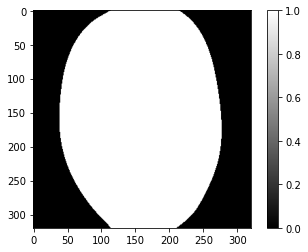

In [9]:
intersection_mask = CS_bitmask & sense_bitmask
plt.imshow(intersection_mask[slice], cmap='gray')
plt.colorbar()


In [10]:
def nmse_mask(gt: np.ndarray, pred: np.ndarray, mask: np.ndarray) -> np.ndarray:
    gt = np.where(mask == 1, gt, 0)
    pred = np.where(mask == 1, pred, 0)
    return nmse(gt,pred)

def psnr_mask(gt: np.ndarray, pred: np.ndarray, mask: np.ndarray) -> np.ndarray:
    gt = np.where(mask == 1, gt, 0)
    pred = np.where(mask == 1, pred, 0)
    return psnr(gt,pred)

def ssim_mask(gt: np.ndarray, pred: np.ndarray, mask: np.ndarray) -> np.ndarray:
    gt = np.where(mask == 1, gt, 0)
    pred = np.where(mask == 1, pred, 0)
    return ssim(gt,pred)

def vgg_loss_mask(gt: np.ndarray, pred: np.ndarray, mask: np.ndarray) -> np.ndarray:
    gt = np.where(mask == 1, gt, 0)
    pred = np.where(mask == 1, pred, 0)
    return vgg_loss(gt,pred)

def stacked_svd_mask(gt: np.ndarray, pred: np.ndarray, mask: np.ndarray) -> np.ndarray:
    gt = np.where(mask == 1, gt, 0)
    pred = np.where(mask == 1, pred, 0)
    return stacked_svd(gt,pred)


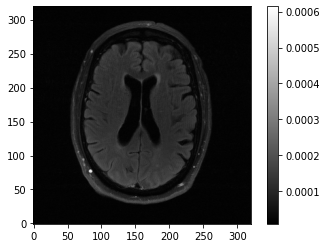

In [11]:
# GT
fig, ax = plt.subplots()
im = ax.imshow(GT[slice], cmap='gray', origin='lower')
plt.colorbar(im, ax=ax)
plt.show()


In [12]:
vmin, vmax = im.get_clim()


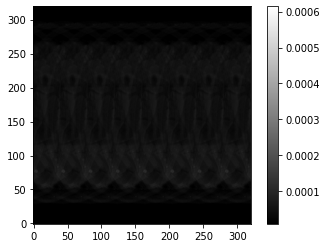

In [26]:
# ZF without ACS
plt.imshow(reconstruction_ZF_noACS[slice], cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()


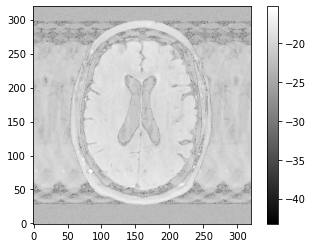

In [27]:
plt.imshow(np.log((GT[slice]-reconstruction_ZF_noACS[slice])**2), cmap='gray', origin='lower')
plt.colorbar()


In [28]:
print(f'NMSE: {nmse(GT,reconstruction_ZF_noACS)}')
print(f'PSNR: {psnr(GT,reconstruction_ZF_noACS)}')
print(f'SSIM: {ssim(GT,reconstruction_ZF_noACS)}')
print(f'VGG: {vgg_loss(GT,reconstruction_ZF_noACS)}')
print(f'SVD: {stacked_svd(GT,reconstruction_ZF_noACS)}')


NMSE: 0.4326535918137132
PSNR: 23.919658687022345
SSIM: [0.62521434]
VGG: 0.10483856499195099
SVD: 0.251953125


In [29]:
print(f'NMSE: {nmse_mask(GT,reconstruction_ZF_noACS,intersection_mask)}')
print(f'PSNR: {psnr_mask(GT,reconstruction_ZF_noACS,intersection_mask)}')
print(f'SSIM: {ssim_mask(GT,reconstruction_ZF_noACS,intersection_mask)}')
print(f'VGG: {vgg_loss_mask(GT,reconstruction_ZF_noACS,intersection_mask)}')
print(f'SVD: {stacked_svd_mask(GT,reconstruction_ZF_noACS,intersection_mask)}')


NMSE: 0.39920147578812
PSNR: 24.459684361417242
SSIM: [0.75890242]
VGG: 0.09922612458467484
SVD: 0.224609375


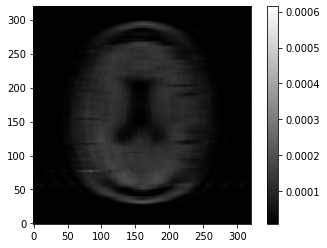

In [30]:
# ZF
plt.imshow(reconstruction_ZF[slice], cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()


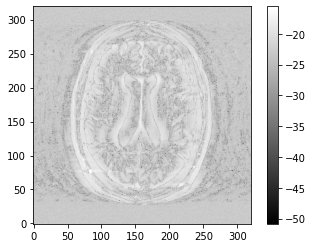

In [31]:
plt.imshow(np.log((GT[slice]-reconstruction_ZF[slice])**2), cmap='gray', origin='lower')
plt.colorbar()


In [32]:
print(f'NMSE: {nmse(GT,reconstruction_ZF)}')
print(f'PSNR: {psnr(GT,reconstruction_ZF)}')
print(f'SSIM: {ssim(GT,reconstruction_ZF)}')
print(f'VGG: {vgg_loss(GT,reconstruction_ZF)}')
print(f'SVD: {stacked_svd(GT,reconstruction_ZF)}')


NMSE: 0.09476713733193431
PSNR: 30.51452127021313
SSIM: [0.73495743]
VGG: 0.10361874103546143
SVD: 0.27421875


In [33]:
print(f'NMSE: {nmse_mask(GT,reconstruction_ZF,intersection_mask)}')
print(f'PSNR: {psnr_mask(GT,reconstruction_ZF,intersection_mask)}')
print(f'SSIM: {ssim_mask(GT,reconstruction_ZF,intersection_mask)}')
print(f'VGG: {vgg_loss_mask(GT,reconstruction_ZF,intersection_mask)}')
print(f'SVD: {stacked_svd_mask(GT,reconstruction_ZF,intersection_mask)}')


NMSE: 0.08478634476153957
PSNR: 31.188351010779627
SSIM: [0.85243088]
VGG: 0.10654830932617188
SVD: 0.230078125


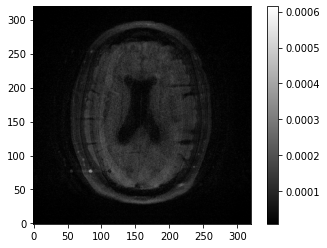

In [34]:
# Grappa
plt.imshow(reconstruction_grappa[slice], cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()


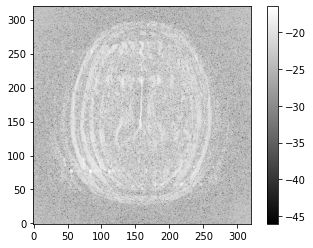

In [35]:
plt.imshow(np.log((GT[slice]-reconstruction_grappa[slice])**2), cmap='gray', origin='lower')
plt.colorbar()


In [36]:
print(f'NMSE: {nmse(GT,reconstruction_grappa)}')
print(f'PSNR: {psnr(GT,reconstruction_grappa)}')
print(f'SSIM: {ssim(GT,reconstruction_grappa)}')
print(f'VGG: {vgg_loss(GT,reconstruction_grappa)}')
print(f'SVD: {stacked_svd(GT,reconstruction_grappa)}')


NMSE: 0.06610109711839658
PSNR: 32.07899684401012
SSIM: [0.79038666]
VGG: 0.07917311042547226
SVD: 0.3794921875


In [37]:
print(f'NMSE: {nmse_mask(GT,reconstruction_grappa,intersection_mask)}')
print(f'PSNR: {psnr_mask(GT,reconstruction_grappa,intersection_mask)}')
print(f'SSIM: {ssim_mask(GT,reconstruction_grappa,intersection_mask)}')
print(f'VGG: {vgg_loss_mask(GT,reconstruction_grappa,intersection_mask)}')
print(f'SVD: {stacked_svd_mask(GT,reconstruction_grappa,intersection_mask)}')


NMSE: 0.05935993747663588
PSNR: 32.736666193490436
SSIM: [0.86734053]
VGG: 0.07899433374404907
SVD: 0.315234375


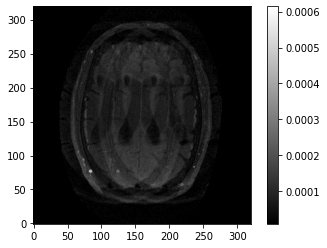

In [38]:
# Sense
plt.imshow(reconstruction_sense[slice], cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()


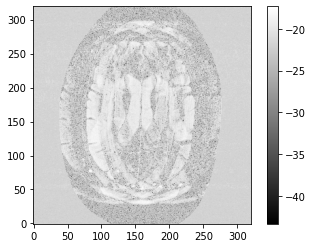

In [39]:
plt.imshow(np.log((GT[slice]-reconstruction_sense[slice])**2), cmap='gray', origin='lower')
plt.colorbar()


In [40]:
print(f'NMSE: {nmse(GT,reconstruction_sense)}')
print(f'PSNR: {psnr(GT,reconstruction_sense)}')
print(f'SSIM: {ssim(GT,reconstruction_sense)}')
print(f'VGG: {vgg_loss(GT,reconstruction_sense)}')
print(f'SVD: {stacked_svd(GT,reconstruction_sense)}')


NMSE: 0.12760413841106555
PSNR: 29.222455468259856
SSIM: [0.43091014]
VGG: 0.08195645362138748
SVD: 0.4234375


In [41]:
print(f'NMSE: {nmse_mask(GT,reconstruction_sense,intersection_mask)}')
print(f'PSNR: {psnr_mask(GT,reconstruction_sense,intersection_mask)}')
print(f'SSIM: {ssim_mask(GT,reconstruction_sense,intersection_mask)}')
print(f'VGG: {vgg_loss_mask(GT,reconstruction_sense,intersection_mask)}')
print(f'SVD: {stacked_svd_mask(GT,reconstruction_sense,intersection_mask)}')


NMSE: 0.08848471898874284
PSNR: 31.002926540159468
SSIM: [0.85911616]
VGG: 0.07691917568445206
SVD: 0.325390625


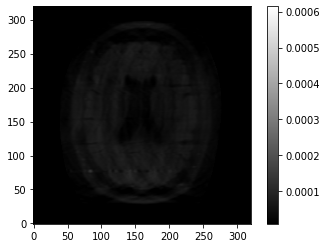

In [42]:
# CS
plt.imshow(reconstruction_CS[slice], cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()


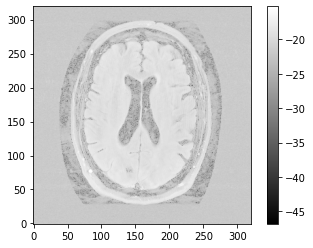

In [43]:
plt.imshow(np.log((GT[slice]-reconstruction_CS[slice])**2), cmap='gray', origin='lower')
plt.colorbar()


In [44]:
print(f'NMSE: {nmse(GT,reconstruction_CS)}')
print(f'PSNR: {psnr(GT,reconstruction_CS)}')
print(f'SSIM: {ssim(GT,reconstruction_CS)}')
print(f'VGG: {vgg_loss(GT,reconstruction_CS)}')
print(f'SVD: {stacked_svd(GT,reconstruction_CS)}')


NMSE: 0.3691724862852144
PSNR: 24.608814636532216
SSIM: [0.33074648]
VGG: 0.10420247912406921
SVD: 0.26171875


In [45]:
print(f'NMSE: {nmse_mask(GT,reconstruction_CS,intersection_mask)}')
print(f'PSNR: {psnr_mask(GT,reconstruction_CS,intersection_mask)}')
print(f'SSIM: {ssim_mask(GT,reconstruction_CS,intersection_mask)}')
print(f'VGG: {vgg_loss_mask(GT,reconstruction_CS,intersection_mask)}')
print(f'SVD: {stacked_svd_mask(GT,reconstruction_CS,intersection_mask)}')


NMSE: 0.3408853013105033
PSNR: 25.145529798782242
SSIM: [0.75933062]
VGG: 0.10758677124977112
SVD: 0.2294921875


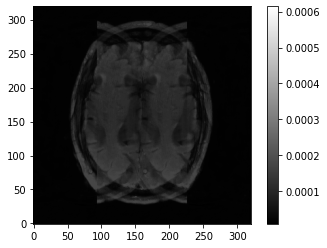

In [13]:
# ZF UNet without ACS
plt.imshow(reconstruction_ZF_unet_noACS[slice], cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()


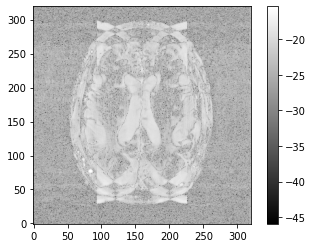

In [14]:
plt.imshow(np.log((GT[slice]-reconstruction_ZF_unet_noACS[slice])**2), cmap='gray', origin='lower')
plt.colorbar()


In [15]:
print(f'NMSE: {nmse(GT,reconstruction_ZF_unet_noACS)}')
print(f'PSNR: {psnr(GT,reconstruction_ZF_unet_noACS)}')
print(f'SSIM: {ssim(GT,reconstruction_ZF_unet_noACS)}')
print(f'VGG: {vgg_loss(GT,reconstruction_ZF_unet_noACS)}')
print(f'SVD: {stacked_svd(GT,reconstruction_ZF_unet_noACS)}')


NMSE: 0.11253234528039624
PSNR: 29.768175609260933
SSIM: [0.86230084]
VGG: 0.09196347743272781
SVD: 0.2501953125


In [16]:
print(f'NMSE: {nmse_mask(GT,reconstruction_ZF_unet_noACS,intersection_mask)}')
print(f'PSNR: {psnr_mask(GT,reconstruction_ZF_unet_noACS,intersection_mask)}')
print(f'SSIM: {ssim_mask(GT,reconstruction_ZF_unet_noACS,intersection_mask)}')
print(f'VGG: {vgg_loss_mask(GT,reconstruction_ZF_unet_noACS,intersection_mask)}')
print(f'SVD: {stacked_svd_mask(GT,reconstruction_ZF_unet_noACS,intersection_mask)}')


NMSE: 0.11539134541112907
PSNR: 29.84985316573052
SSIM: [0.87669293]
VGG: 0.09177642315626144
SVD: 0.240234375


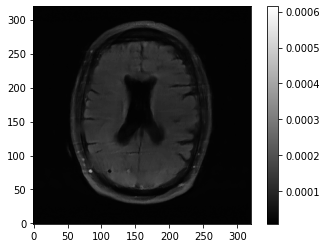

In [46]:
# ZF UNet
plt.imshow(reconstruction_ZF_unet[slice], cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()


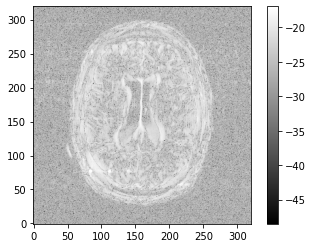

In [47]:
plt.imshow(np.log((GT[slice]-reconstruction_ZF_unet[slice])**2), cmap='gray', origin='lower')
plt.colorbar()


In [48]:
print(f'NMSE: {nmse(GT,reconstruction_ZF_unet)}')
print(f'PSNR: {psnr(GT,reconstruction_ZF_unet)}')
print(f'SSIM: {ssim(GT,reconstruction_ZF_unet)}')
print(f'VGG: {vgg_loss(GT,reconstruction_ZF_unet)}')
print(f'SVD: {stacked_svd(GT,reconstruction_ZF_unet)}')


NMSE: 0.036266367689356906
PSNR: 34.68598213596095
SSIM: [0.91652023]
VGG: 0.05699826776981354
SVD: 0.289453125


In [49]:
print(f'NMSE: {nmse_mask(GT,reconstruction_ZF_unet,intersection_mask)}')
print(f'PSNR: {psnr_mask(GT,reconstruction_ZF_unet,intersection_mask)}')
print(f'SSIM: {ssim_mask(GT,reconstruction_ZF_unet,intersection_mask)}')
print(f'VGG: {vgg_loss_mask(GT,reconstruction_ZF_unet,intersection_mask)}')
print(f'SVD: {stacked_svd_mask(GT,reconstruction_ZF_unet,intersection_mask)}')


NMSE: 0.0363655985058179
PSNR: 34.86468467772358
SSIM: [0.92878261]
VGG: 0.05809759721159935
SVD: 0.2650390625


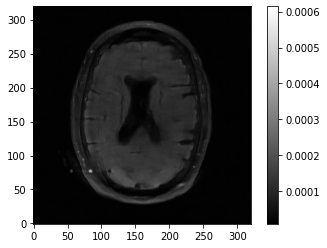

In [50]:
# Grappa UNet
plt.imshow(reconstruction_grappa_unet[slice], cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()


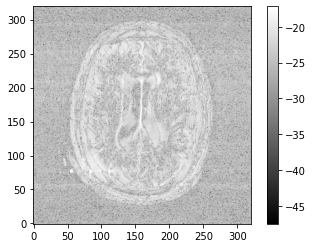

In [51]:
plt.imshow(np.log((GT[slice]-reconstruction_grappa_unet[slice])**2), cmap='gray', origin='lower')
plt.colorbar()


In [52]:
print(f'NMSE: {nmse(GT,reconstruction_grappa_unet)}')
print(f'PSNR: {psnr(GT,reconstruction_grappa_unet)}')
print(f'SSIM: {ssim(GT,reconstruction_grappa_unet)}')
print(f'VGG: {vgg_loss(GT,reconstruction_grappa_unet)}')
print(f'SVD: {stacked_svd(GT,reconstruction_grappa_unet)}')


NMSE: 0.03630715300797851
PSNR: 34.68113534062776
SSIM: [0.90606571]
VGG: 0.05969218537211418
SVD: 0.3173828125


In [53]:
print(f'NMSE: {nmse_mask(GT,reconstruction_grappa_unet,intersection_mask)}')
print(f'PSNR: {psnr_mask(GT,reconstruction_grappa_unet,intersection_mask)}')
print(f'SSIM: {ssim_mask(GT,reconstruction_grappa_unet,intersection_mask)}')
print(f'VGG: {vgg_loss_mask(GT,reconstruction_grappa_unet,intersection_mask)}')
print(f'SVD: {stacked_svd_mask(GT,reconstruction_grappa_unet,intersection_mask)}')


NMSE: 0.03529272522392911
PSNR: 34.99475018757546
SSIM: [0.92503381]
VGG: 0.06318435817956924
SVD: 0.2814453125


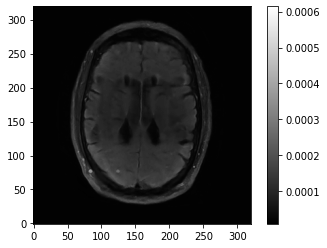

In [54]:
# Sense UNet
plt.imshow(reconstruction_sense_unet[slice], cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()


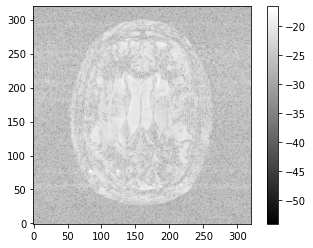

In [55]:
plt.imshow(np.log((GT[slice]-reconstruction_sense_unet[slice])**2), cmap='gray', origin='lower')
plt.colorbar()


In [56]:
print(f'NMSE: {nmse(GT,reconstruction_sense_unet)}')
print(f'PSNR: {psnr(GT,reconstruction_sense_unet)}')
print(f'SSIM: {ssim(GT,reconstruction_sense_unet)}')
print(f'VGG: {vgg_loss(GT,reconstruction_sense_unet)}')
print(f'SVD: {stacked_svd(GT,reconstruction_sense_unet)}')


NMSE: 0.042472609209019914
PSNR: 33.99992967128992
SSIM: [0.91296989]
VGG: 0.0576138012111187
SVD: 0.3015625


In [57]:
print(f'NMSE: {nmse_mask(GT,reconstruction_sense_unet,intersection_mask)}')
print(f'PSNR: {psnr_mask(GT,reconstruction_sense_unet,intersection_mask)}')
print(f'SSIM: {ssim_mask(GT,reconstruction_sense_unet,intersection_mask)}')
print(f'VGG: {vgg_loss_mask(GT,reconstruction_sense_unet,intersection_mask)}')
print(f'SVD: {stacked_svd_mask(GT,reconstruction_sense_unet,intersection_mask)}')


NMSE: 0.042105965422241924
PSNR: 34.22815584130948
SSIM: [0.93121411]
VGG: 0.059715546667575836
SVD: 0.27109375


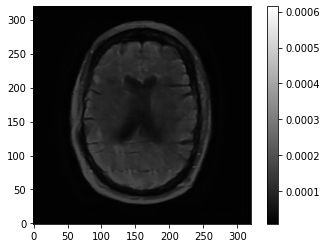

In [58]:
# CS UNet
plt.imshow(reconstruction_cs_unet[slice], cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()


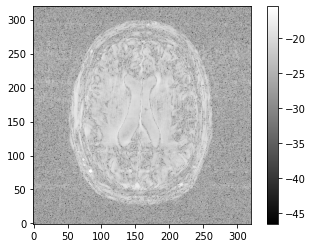

In [59]:
plt.imshow(np.log((GT[slice]-reconstruction_cs_unet[slice])**2), cmap='gray', origin='lower')
plt.colorbar()


In [60]:
print(f'NMSE: {nmse(GT,reconstruction_cs_unet)}')
print(f'PSNR: {psnr(GT,reconstruction_cs_unet)}')
print(f'SSIM: {ssim(GT,reconstruction_cs_unet)}')
print(f'VGG: {vgg_loss(GT,reconstruction_cs_unet)}')
print(f'SVD: {stacked_svd(GT,reconstruction_cs_unet)}')


NMSE: 0.05523577697225225
PSNR: 32.85887529534796
SSIM: [0.87445114]
VGG: 0.07563704252243042
SVD: 0.289453125


In [61]:
print(f'NMSE: {nmse_mask(GT,reconstruction_cs_unet,intersection_mask)}')
print(f'PSNR: {psnr_mask(GT,reconstruction_cs_unet,intersection_mask)}')
print(f'SSIM: {ssim_mask(GT,reconstruction_cs_unet,intersection_mask)}')
print(f'VGG: {vgg_loss_mask(GT,reconstruction_cs_unet,intersection_mask)}')
print(f'SVD: {stacked_svd_mask(GT,reconstruction_cs_unet,intersection_mask)}')


NMSE: 0.05290420214324558
PSNR: 33.23670011072674
SSIM: [0.91184666]
VGG: 0.07883719354867935
SVD: 0.25859375
